# Project Title

## Overview

Short project description. Your bottom line up front (BLUF) insights.

## Business Understanding

Text here

## Data Understanding

Text here

In [86]:
# Import lib
import pandas as pd
import numpy as np
from pathlib import Path

# Stats
from scipy.stats import chi2_contingency, mannwhitneyu, spearmanr
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Visual
import matplotlib.pyplot as plt
import seaborn as sns

# Note. I am having issues using statsmodels for some reason!!


In [5]:
# Data Import
df = pd.read_csv("data/US_Accidents_March23.csv")
df.head(3)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day


Documentation for Variables:

ID                          : Unique Accident Identifier                                           : Will be useful as an index...
Source                      : Data Provider                                                        : Low relevance to our project here...
Severity                    : Accident serverity scale measured from 1 to 4 with 4 being the worst : Target var
Start_Time / End_Time       : Timestamp accident began / Ended                                     : Key for time based pattern analysis
Start_Lat / Start_Lng       : Accident Location                                                    : Used for mapping, spatial clustering, identifying hotspots
End_Lat / End_Lng           : End Location if known                                                : Rarely filled
Distance                    : Estimated impact length                                              : Possible proxy mapping for severity
Description.                : Accident description.                                                : Not needed
Street/City/Count/State/Zip : Location description                                                 : Good for geo analysis in our case
Country                     : Basically same thing as above                                        : Not useful
Time                        : Not Useful                                                           : Not needed
Airport_Code                : Closest Airport                                                      : Not needed
Weather                     : Time weather was recorded                                            : Can help with conditional analysis
Temp                        : Temp at time of accident                                             : Weather factor. Again useful for predictions
Humidity                    : Relative humidity                                                    : Weather factor. Again useful for predictions
Pressure                    : Atmospheric pressure                                                 : Rarely directly relevant
Visibility                  : Visiblity distance                                                   : KEY RISK FACTOR
Wind_Direction              : Wind cond                                                            : Minor risk factor
Precipitation               : Precipitation at time                                                : Important weather factor
Weather_Condition           : Weather descriptior                                                  : good for categorical risk
Road_Signs                  : Boolean road feature flags                                           : good for infrastructural insights
Sunrise_Sunset              : Lighting conditions for "Day" or "Night"                             : Core for lign analysis


In [7]:
# Assess data quality issues
print("Shape", df.shape)
print("\nData Types:")
print(df.dtypes.sort_index())

# Footprint
mem_mb = df.memory_usage(deep=True).sum() / 1024**3
print(f"\nEstimated Memory: {mem_mb:.1f} MB")

Shape (7728394, 46)

Data Types:
Airport_Code              object
Amenity                     bool
Astronomical_Twilight     object
Bump                        bool
City                      object
Civil_Twilight            object
Country                   object
County                    object
Crossing                    bool
Description               object
Distance(mi)             float64
End_Lat                  float64
End_Lng                  float64
End_Time                  object
Give_Way                    bool
Humidity(%)              float64
ID                        object
Junction                    bool
Nautical_Twilight         object
No_Exit                     bool
Precipitation(in)        float64
Pressure(in)             float64
Railway                     bool
Roundabout                  bool
Severity                   int64
Source                    object
Start_Lat                float64
Start_Lng                float64
Start_Time                object
State     

In [8]:
# Overview sorted (table)
na_table = (
    df.isna()
      .mean()
      .mul(100)
      .sort_values(ascending=False)
      .round(2)
      .rename("missing_%")
      .to_frame()
)

na_table.head(20)

,missing_%
End_Lat,44.03
End_Lng,44.03
Precipitation(in),28.51
Wind_Chill(F),25.87
Wind_Speed(mph),7.39
Visibility(mi),2.29
Wind_Direction,2.27
Humidity(%),2.25
Weather_Condition,2.24
Temperature(F),2.12


In [9]:
# Dup checking
dup_id = df["ID"].duplicated().sum() if "ID" in df.columns else 0
dup_all = df.duplicated().sum()
print(f"Duplicate IDs: {dup_id}")
print(f"Fully duplicated rows: {dup_all}")

Duplicate IDs: 0
Fully duplicated rows: 0


In [10]:
# Key categoricals: Value Distributions
cat_col = [
    c for c in [
        "Severity","State","City","Source","Sunrise_Sunset","Weather_Condition",
        "Civil_Twilight","Nautical_Twilight","Astronomical_Twilight"
    ] if c in df.columns
]

for c in cat_col:
    print(f"\n-=- {c} (top 15) -=-")
    display(df[c].value_counts(dropna=False).head(15))


-=- Severity (top 15) -=-


Severity
2    6156981
3    1299337
4     204710
1      67366
Name: count, dtype: int64


-=- State (top 15) -=-


State
CA    1741433
FL     880192
TX     582837
SC     382557
NY     347960
NC     338199
VA     303301
PA     296620
MN     192084
OR     179660
AZ     170609
GA     169234
IL     168958
TN     167388
MI     162191
Name: count, dtype: int64


-=- City (top 15) -=-


City
Miami          186917
Houston        169609
Los Angeles    156491
Charlotte      138652
Dallas         130939
Orlando        109733
Austin          97359
Raleigh         86079
Nashville       72930
Baton Rouge     71588
Atlanta         68186
Sacramento      66264
San Diego       55504
Phoenix         53974
Minneapolis     51488
Name: count, dtype: int64


-=- Source (top 15) -=-


Source
Source1    4325632
Source2    3305373
Source3      97389
Name: count, dtype: int64


-=- Sunrise_Sunset (top 15) -=-


Sunrise_Sunset
Day      5334553
Night    2370595
NaN        23246
Name: count, dtype: int64


-=- Weather_Condition (top 15) -=-


Weather_Condition
Fair                2560802
Mostly Cloudy       1016195
Cloudy               817082
Clear                808743
Partly Cloudy        698972
Overcast             382866
Light Rain           352957
Scattered Clouds     204829
NaN                  173459
Light Snow           128680
Fog                   99238
Rain                  84331
Haze                  76223
Fair / Windy          35671
Heavy Rain            32309
Name: count, dtype: int64


-=- Civil_Twilight (top 15) -=-


Civil_Twilight
Day      5695619
Night    2009529
NaN        23246
Name: count, dtype: int64


-=- Nautical_Twilight (top 15) -=-


Nautical_Twilight
Day      6076156
Night    1628992
NaN        23246
Name: count, dtype: int64


-=- Astronomical_Twilight (top 15) -=-


Astronomical_Twilight
Day      6377548
Night    1327600
NaN        23246
Name: count, dtype: int64

In [11]:
# Sev distribution and bin target
if "Severity" in df.columns:
    sev_counts = df["Severity"].value_counts(dropna=False).sort_index()
    sev_rate = (sev_counts / sev_counts.sum() * 100).round(2)
    display(pd.DataFrame({"count": sev_counts, "percent": sev_rate}))

    # Bin severe (>= 3)
    df["severe_bin"] = (df["Severity"] >= 3).astype("int8")
    severe_rate = df["severe_bin"].mean() * 100
    print(f"\nSevere (>= 3) rate: {severe_rate:.2f}%")

,count,percent
Severity,,
1,67366,0.87
2,6156981,79.67
3,1299337,16.81
4,204710,2.65



Severe (>= 3) rate: 19.46%


In [12]:
# Bool road-features like the signs and intersections

bool_like = [
    "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
    "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
]

present_bools = [c for c in bool_like if c in df.columns]

def to_bool_series(s):
    """Coerce typical string/number truthy/falsey into 0/1 (keeps NaN)."""
    return (s.astype(str).str.strip().str.lower()
              .map({"true":1,"t":1,"1":1,"yes":1,"y":1,"on":1,
                    "false":0,"f":0,"0":0,"no":0,"n":0,"off":0}))

bool_summary = []
for c in present_bools:
    ser = df[c] if df[c].dtype == "boolean" else to_bool_series(df[c])
    rate_true = ser.mean() * 100
    bool_summary.append((c, float(rate_true), int(ser.isna().sum())))

bool_df = pd.DataFrame(bool_summary, columns=["column","%_true","n_missing"]).sort_values("%_true", ascending=False)
bool_df

,column,%_true,n_missing
11,Traffic_Signal,14.799608,0
2,Crossing,11.305881,0
4,Junction,7.392765,0
9,Stop,2.773810,0
8,Station,2.612457,0
0,Amenity,1.246494,0
6,Railway,0.866661,0
3,Give_Way,0.473345,0
5,No_Exit,0.252899,0
10,Traffic_Calming,0.098313,0


In [13]:
# Num columns and sum stats

num_cols = df.select_dtypes(include=["number", "float", "int"]).columns.tolist()

extras = ["Visibility(mi)","Precipitation(in)","Wind_Speed(mph)","Temperature(F)","Distance(mi)","Start_Lat","Start_Lng","End_Lat","End_Lng"]
for c in extras:
    if c in df.columns and c not in num_cols:
        df[c] = pd.to_numeric(df[c], errors = "coerce")
        num_cols.append(c)

desc = df[num_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T
desc[["count","mean","std","min","1%","5%","25%","50%","75%","95%","99%","max"]].round(3)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Severity,7728394.0,2.212,0.488,1.000,2.000,2.000,2.000,2.000,2.000,3.000,4.000,4.000
Start_Lat,7728394.0,36.201,5.076,24.555,25.733,27.112,33.400,35.824,40.085,44.859,47.479,49.002
Start_Lng,7728394.0,-94.703,17.392,-124.624,-122.959,-122.192,-117.219,-87.767,-80.354,-73.956,-71.482,-67.113
End_Lat,4325632.0,36.262,5.273,24.566,25.687,26.030,33.462,36.183,40.179,44.982,47.274,49.075
End_Lng,4325632.0,-95.726,18.108,-124.546,-123.200,-122.264,-117.754,-88.028,-80.247,-74.024,-72.854,-67.109
Distance(mi),7728394.0,0.562,1.777,0.000,0.000,0.000,0.000,0.030,0.464,2.670,6.955,441.750
Temperature(F),7564541.0,61.663,19.014,-89.000,12.200,28.000,49.000,64.000,76.000,89.000,96.000,207.000
Wind_Chill(F),5729375.0,58.251,22.390,-89.000,-2.000,18.000,43.000,62.000,75.000,88.000,96.000,207.000
Humidity(%),7554250.0,64.831,22.821,1.000,12.000,24.000,48.000,67.000,84.000,97.000,100.000,100.000
Pressure(in),7587715.0,29.539,1.006,0.000,24.580,27.980,29.370,29.860,30.030,30.260,30.440,58.630


In [14]:
# IQR-based outlier
def iqr_outlier_share(s):
    s = s.dropna()
    if s.empty: return np.nan
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return ((s < lo) | (s > hi)).mean() * 100

outlier_rows = []
check_cols = [c for c in ["Visibility(mi)","Precipitation(in)","Wind_Speed(mph)","Temperature(F)","Distance(mi)"] if c in df.columns]
for c in check_cols:
    outlier_rows.append((c, round(iqr_outlier_share(df[c]), 2)))

pd.DataFrame(outlier_rows, columns=["columns", "%_outliers_est"])

,columns,%_outliers_est
0,Visibility(mi),19.61
1,Precipitation(in),9.65
2,Wind_Speed(mph),2.94
3,Temperature(F),0.67
4,Distance(mi),12.47


In [15]:
# Categor cleaning checks (to stop any funny business from happening later on)

if "Sunrise_Sunset" in df.columns:
    print("Sunrise_Sunset unique values:", sorted(df["Sunrise_Sunset"].dropna().unique().tolist())[:20])

if "Weather_Condition" in df.columns:
    display(df["Weather_Condition"].value_counts().head(30))

Sunrise_Sunset unique values: ['Day', 'Night']


Weather_Condition
Fair                            2560802
Mostly Cloudy                   1016195
Cloudy                           817082
Clear                            808743
Partly Cloudy                    698972
Overcast                         382866
Light Rain                       352957
Scattered Clouds                 204829
Light Snow                       128680
Fog                               99238
Rain                              84331
Haze                              76223
Fair / Windy                      35671
Heavy Rain                        32309
Light Drizzle                     22684
Thunder in the Vicinity           17611
Cloudy / Windy                    17035
T-Storm                           16810
Mostly Cloudy / Windy             16508
Snow                              15537
Thunder                           14202
Light Rain with Thunder           13597
Smoke                             12668
Wintry Mix                        11703
Partly Cloudy / Windy 

In [16]:
# Quick, quality checks

# Nothing too extensive
report = {}

# Missings
report["missing_top10"] = na_table.head(10)


# Duplicates
report["duplicate_ids"] = int(dup_id) if "ID" in df.columns else "N/A"
report["duplicate_rows"] = int(dup_all)

# Sev
if "Severity" in df.columns:
    report["severity_counts"] = df["Severity"].value_counts().sort_index()
    report["severe_rate_%"] = round(df["severe_bin"].mean()*100, 2)

# Bools
if present_bools:
    report["bool_flags"] = bool_df

# Num snapshot
report["numeric_summary"] = desc[["count","mean","std","min","1%","5%","50%","95%","99%","max"]].round(3)

# Show report pieces
for k, v in report.items():
    print(f"\n-=- {k} -=-")
    display(v)



-=- missing_top10 -=-


,missing_%
End_Lat,44.03
End_Lng,44.03
Precipitation(in),28.51
Wind_Chill(F),25.87
Wind_Speed(mph),7.39
Visibility(mi),2.29
Wind_Direction,2.27
Humidity(%),2.25
Weather_Condition,2.24
Temperature(F),2.12



-=- duplicate_ids -=-


0


-=- duplicate_rows -=-


0


-=- severity_counts -=-


Severity
1      67366
2    6156981
3    1299337
4     204710
Name: count, dtype: int64


-=- severe_rate_% -=-


np.float64(19.46)


-=- bool_flags -=-


,column,%_true,n_missing
11,Traffic_Signal,14.799608,0
2,Crossing,11.305881,0
4,Junction,7.392765,0
9,Stop,2.773810,0
8,Station,2.612457,0
0,Amenity,1.246494,0
6,Railway,0.866661,0
3,Give_Way,0.473345,0
5,No_Exit,0.252899,0
10,Traffic_Calming,0.098313,0



-=- numeric_summary -=-


,count,mean,std,min,1%,5%,50%,95%,99%,max
Severity,7728394.0,2.212,0.488,1.000,2.000,2.000,2.000,3.000,4.000,4.000
Start_Lat,7728394.0,36.201,5.076,24.555,25.733,27.112,35.824,44.859,47.479,49.002
Start_Lng,7728394.0,-94.703,17.392,-124.624,-122.959,-122.192,-87.767,-73.956,-71.482,-67.113
End_Lat,4325632.0,36.262,5.273,24.566,25.687,26.030,36.183,44.982,47.274,49.075
End_Lng,4325632.0,-95.726,18.108,-124.546,-123.200,-122.264,-88.028,-74.024,-72.854,-67.109
Distance(mi),7728394.0,0.562,1.777,0.000,0.000,0.000,0.030,2.670,6.955,441.750
Temperature(F),7564541.0,61.663,19.014,-89.000,12.200,28.000,64.000,89.000,96.000,207.000
Wind_Chill(F),5729375.0,58.251,22.390,-89.000,-2.000,18.000,62.000,88.000,96.000,207.000
Humidity(%),7554250.0,64.831,22.821,1.000,12.000,24.000,67.000,97.000,100.000,100.000
Pressure(in),7587715.0,29.539,1.006,0.000,24.580,27.980,29.860,30.260,30.440,58.630


Stuff to note: Sorry for the spelling and grammar mistakes (these are more quick notes for myself)

There seems to be a class imbalnace in Severity Distribution. Class 2 ~ 80% of cases while class 4 and class 1 are standing out. Knowing this, if we do any modeling or statistical tests, we have to account for this.

Additionally there is imbalances in geographical columns, and scores.

For source; most suggest to be covered by provider. 

Time & Lighting show around ~69% of accidents happen during the day, whiel only ~31% happen at night. There are missing values

Weather seems to be messy and really granular. 

The most infrastructure flags occur at traffic signals, crossings, and junctions.



## Data Preparation & Cleaning
Given what we have learned from the above reports, we know that we need to drop columns (end_lat/end_lng) as there are too many nan and its not critical. We need to clean outliers on distance, temp, wind_speed, precip, and visibility. We need to impute missing in weather fields, and weather conditions. Lastly, we need to make sure we take note of the imbalances.

In [17]:
# display (again)
df.head(3)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,severe_bin
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,Night,Night,Night,Night,1
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,Night,Night,Night,Day,0
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,True,False,Night,Night,Day,Day,0


In [18]:
# Drop redundant/low-value columns

df_prep = df.copy()

drop_cols = [
    "End_Lat","End_Lng", "Civil_Twilight","Nautical_Twilight","Astronomical_Twilight", "Airport_Code","Country","Timezone","Weather_Timestamp","Description","Street"
]

present = [c for c in drop_cols if c in df_prep.columns]
df_prep = df_prep.drop(columns = present)
print("Dropped:", present)
print("Shape now:", df_prep.shape)
df_prep.head(3)

Dropped: ['End_Lat', 'End_Lng', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Airport_Code', 'Country', 'Timezone', 'Weather_Timestamp', 'Description', 'Street']
Shape now: (7728394, 36)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),City,County,...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,severe_bin
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,Dayton,Montgomery,...,False,False,False,False,False,False,False,False,Night,1
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,Reynoldsburg,Franklin,...,False,False,False,False,False,False,False,False,Night,0
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,Williamsburg,Clermont,...,False,False,False,False,False,False,True,False,Night,0


In [19]:
# missing-value handling

if "Weather_Condition" in df_prep:
    before = df_prep["Weather_Condition"].isna().sum()
    df_prep["Weather_Condition"] = df_prep["Weather_Condition"].fillna("Unknown")
    after = df_prep["Weather_Condition"].isna().sum()
    print(f"Weather_Condition NaN: {before} to {after}")

num_impute_cols = [
    "Visibility(mi)","Wind_Speed(mph)","Temperature(F)","Pressure(in)","Humidity(%)"
]

for col in num_impute_cols:
    if col in df_prep:
        before = df_prep[col].isna().sum()
        med = df_prep[col].median()
        df_prep[col] = df_prep[col].fillna(med)
        after = df_prep[col].isna().sum()
        print(f"{col} NaN: {before} to {after} (median = {med:.3f})")

if "Precipitation(in)" in df_prep:
    before = df_prep["Precipitation(in)"].isna().sum()
    clear_mask = df_prep["Weather_Condition"].str.contains("Fair|Clear", case=False, na=False)
    df_prep.loc[clear_mask, "Precipitation(in)"] = df_prep.loc[clear_mask, "Precipitation(in)"].fillna(0)
    medp = df_prep["Precipitation(in)"].median()
    df_prep["Precipitation(in)"] = df_prep["Precipitation(in)"].fillna(medp)
    after = df_prep["Precipitation(in)"].isna().sum()
    print(f"Precipitation(in) NaN: {before} to {after} (median={medp:.3f})")

if "Wind_Chill(F)" in df_prep:
    df_prep = df_prep.drop(columns=["Wind_Chill(F)"])
    print("Dropped: Wind_Chill(F)")

df_prep.head(3)

Weather_Condition NaN: 173459 to 0
Visibility(mi) NaN: 177098 to 0 (median = 10.000)
Wind_Speed(mph) NaN: 571233 to 0 (median = 7.000)
Temperature(F) NaN: 163853 to 0 (median = 64.000)
Pressure(in) NaN: 140679 to 0 (median = 29.860)
Humidity(%) NaN: 174144 to 0 (median = 67.000)
Precipitation(in) NaN: 2203586 to 0 (median=0.000)
Dropped: Wind_Chill(F)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),City,County,...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,severe_bin
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,Dayton,Montgomery,...,False,False,False,False,False,False,False,False,Night,1
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,Reynoldsburg,Franklin,...,False,False,False,False,False,False,False,False,Night,0
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,Williamsburg,Clermont,...,False,False,False,False,False,False,True,False,Night,0


In [20]:
# Cutting off and reorg of crazy outliers

def show_quantiles(s, name):
    q = s.quantile([0.1,0.5,0.5,0.95,0.99])
    return f"{name}: min={s.min():.3f}, 1%={q.iloc[0]:.3f}, 5%={q.iloc[1]:.3f}, 50%={q.iloc[2]:.3f}, 95%={q.iloc[3]:.3f}, 99%={q.iloc[4]:.3f}, max={s.max():.3f}" # hopefully this works

clip_cfg = {
    "Distance(mi)"      : (0, 50),
    "Temperature(F)"    : (-40, 130),
    "Wind_Speed(mph)"   : (0, 100),
    "Visibility(mi)"    : (0, 30),
    "Precipitation(in)" : (0, 3)
}

for col, (lo, hi) in clip_cfg.items():
    if col in df_prep:
        print("Before - ", show_quantiles(df_prep[col], col))
        df_prep[col] = df_prep[col].clip(lo, hi)
        print("After - ", show_quantiles(df_prep[col], col), "\n")

Before -  Distance(mi): min=0.000, 1%=0.000, 5%=0.030, 50%=0.030, 95%=2.670, 99%=6.955, max=441.750
After -  Distance(mi): min=0.000, 1%=0.000, 5%=0.030, 50%=0.030, 95%=2.670, 99%=6.955, max=50.000 

Before -  Temperature(F): min=-89.000, 1%=35.100, 5%=64.000, 50%=64.000, 95%=89.000, 99%=96.000, max=207.000
After -  Temperature(F): min=-40.000, 1%=35.100, 5%=64.000, 50%=64.000, 95%=89.000, 99%=96.000, max=130.000 

Before -  Wind_Speed(mph): min=0.000, 1%=0.000, 5%=7.000, 50%=7.000, 95%=17.000, 99%=23.000, max=1087.000
After -  Wind_Speed(mph): min=0.000, 1%=0.000, 5%=7.000, 50%=7.000, 95%=17.000, 99%=23.000, max=100.000 

Before -  Visibility(mi): min=0.000, 1%=6.000, 5%=10.000, 50%=10.000, 95%=10.000, 99%=10.000, max=140.000
After -  Visibility(mi): min=0.000, 1%=6.000, 5%=10.000, 50%=10.000, 95%=10.000, 99%=10.000, max=30.000 

Before -  Precipitation(in): min=0.000, 1%=0.000, 5%=0.000, 50%=0.000, 95%=0.010, 99%=0.140, max=36.470
After -  Precipitation(in): min=0.000, 1%=0.000, 5%=0

In [21]:
# Simplify Weather Conditions into 7 categorical buckets

def simplify_weather(x: str):
    if pd.isna(x): return "Unknown"
    x = x.lower()
    if "snow" in x or "sleet" in x or "wintry" in x: return "Snow"
    if "rain" in x or "drizzle" in x or "shower" in x: return "Rain"
    if "storm" in x or "thunder" in x or "t-storm" in x: return "Storm"
    if "fog" in x or "mist" in x or "haze" in x or "smoke" in x: return "Fog"
    if "cloud" in x or "overcast" in x: return "Cloudy"
    if "fair" in x or "clear" in x: return "Clear"
    return "Other"

df_prep["Weather_Simple"] = df_prep["Weather_Condition"].map(simplify_weather)
print("Top Weather_Condition (raw) :")
display(df_prep["Weather_Condition"].value_counts().head(10))
print("\nBuckets (Weather_Simple):")
display(df_prep["Weather_Simple"].value_counts())

Top Weather_Condition (raw) :


Weather_Condition
Fair                2560802
Mostly Cloudy       1016195
Cloudy               817082
Clear                808743
Partly Cloudy        698972
Overcast             382866
Light Rain           352957
Scattered Clouds     204829
Unknown              173459
Light Snow           128680
Name: count, dtype: int64


Buckets (Weather_Simple):


Weather_Simple
Clear     3405216
Cloudy    3163750
Rain       540375
Fog        202399
Other      178062
Snow       173360
Storm       65232
Name: count, dtype: int64

In [23]:
# Prep for feature engineering (with time, lighting, rush hours, weekend, target)

# parse time
df_prep["Start_Time"] = pd.to_datetime(df_prep["Start_Time"], errors="coerce")


# Establishing features
df_prep["hour"]         = df_prep["Start_Time"].dt.hour
df_prep["weekday"]      = df_prep["Start_Time"].dt.dayofweek
df_prep["month"]        = df_prep["Start_Time"].dt.month
df_prep["is_weekend"]   = df_prep["weekday"].isin([5,6]).astype("int8")
df_prep["rush_hour"]    = df_prep["hour"].isin([7,8,9,16,17,18]).astype("int8")


# Lighting
df_prep["is_dark"] = df_prep["Sunrise_Sunset"].astype(str).str.lower().eq("night").astype("int8")

# Bin targets >= 3
df_prep["severe_bin"] = (df_prep["Severity"] >= 3).astype("int8")

print(df_prep[["Start_Time","hour","weekday","month","is_weekend","rush_hour","is_dark","severe_bin"]].head(5))

           Start_Time  hour  weekday  month  is_weekend  rush_hour  is_dark  \
0 2016-02-08 05:46:00   5.0      0.0    2.0           0          0        1   
1 2016-02-08 06:07:59   6.0      0.0    2.0           0          0        1   
2 2016-02-08 06:49:27   6.0      0.0    2.0           0          0        1   
3 2016-02-08 07:23:34   7.0      0.0    2.0           0          1        1   
4 2016-02-08 07:39:07   7.0      0.0    2.0           0          1        0   

   severe_bin  
0           1  
1           0  
2           0  
3           1  
4           0  


In [24]:
# Boolean work and light downcasting

bool_cols = ["Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"]

for c in bool_cols:
    if c in df_prep:
        df_prep[c] = df_prep[c].astype(int)

float_cols = ["Distance(mi)","Temperature(F)","Humidity(%)","Pressure(in)","Visibility(mi)","Wind_Speed(mph)","Precipitation(in)","Start_Lat","Start_Lng"]

for c in float_cols:
    if c in df_prep:
        df_prep[c] = pd.to_numeric(df_prep[c], downcast = "float")

print("Dtypes summary:")
print(df_prep.dtypes.sort_index().head(25))


Dtypes summary:
Amenity                       int64
Bump                          int64
City                         object
County                       object
Crossing                      int64
Distance(mi)                float32
End_Time                     object
Give_Way                      int64
Humidity(%)                 float32
ID                           object
Junction                      int64
No_Exit                       int64
Precipitation(in)           float32
Pressure(in)                float32
Railway                       int64
Roundabout                    int64
Severity                      int64
Source                       object
Start_Lat                   float32
Start_Lng                   float32
Start_Time           datetime64[ns]
State                        object
Station                       int64
Stop                          int64
Sunrise_Sunset               object
dtype: object


In [26]:
# Final checks to make sure everything works well

print("Final Shape:", df_prep.shape)

print("\nSevere rate (>=3):", round(100*df_prep["severe_bin"].mean(), 2), "%")
print("\nWeather buckets:")
print(df_prep["Weather_Simple"].value_counts(normalize=True).mul(100).round(1))

df_prep.head(3)

Final Shape: (7728394, 42)

Severe rate (>=3): 19.46 %

Weather buckets:
Weather_Simple
Clear     44.1
Cloudy    40.9
Rain       7.0
Fog        2.6
Other      2.3
Snow       2.2
Storm      0.8
Name: proportion, dtype: float64


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),City,County,...,Turning_Loop,Sunrise_Sunset,severe_bin,Weather_Simple,hour,weekday,month,is_weekend,rush_hour,is_dark
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,Dayton,Montgomery,...,0,Night,1,Rain,5.0,0.0,2.0,0,0,1
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,Reynoldsburg,Franklin,...,0,Night,0,Rain,6.0,0.0,2.0,0,0,1
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,Williamsburg,Clermont,...,0,Night,0,Cloudy,6.0,0.0,2.0,0,0,1


## EDA Analysis

In [57]:
# Moving on to plotting and styling

sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.dpi'] = 120

# Im going to add the below in as a general help...
def rate_table(df, by):
    t = (df.groupby(by)["severe_bin"]
           .agg(crashes="size", severe_rate=lambda s: s.mean() * 100)
           .reset_index())
    # tidy numeric types
    t["crashes"] = t["crashes"].astype("int64")
    t["severe_rate"] = t["severe_rate"].astype("float")
    return t

print("EDA helpers created... Using df_prep with the following shape:", df_prep.shape)

# Side comment: VSCode is really slow. Its my first time using it and its taking forever... 

EDA helpers created... Using df_prep with the following shape: (7728394, 42)


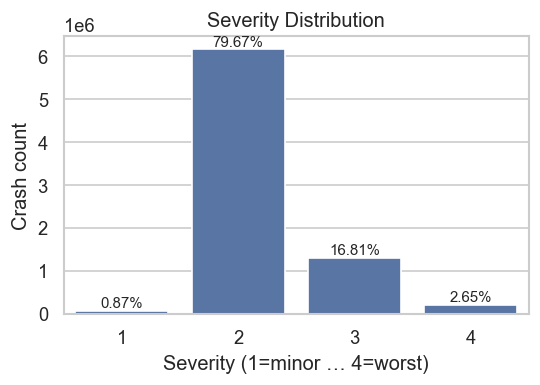

Interpretation: Most crashes are of Severity 2 (~ 79.67 %), severe (≥3) = 19.46 %.


In [58]:
# Sev dist
tab = df_prep["Severity"].value_counts().sort_index()
pct = (100*tab/tab.sum()).round(2)

fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(x=tab.index.astype(str), y=tab.values, ax=ax)
ax.set_title("Severity Distribution")
ax.set_xlabel("Severity (1=minor … 4=worst)")
ax.set_ylabel("Crash count")



# create a for loop to iterate over enumerate(tab.values)
for i, v in enumerate(tab.values):
    ax.text(i, v, f"{pct.iloc[i]}%", ha="center", va="bottom", fontsize=9)

# PLT show
plt.show()

print("Interpretation:",
      "Most crashes are of Severity 2 (~", float(pct.loc[2]), "%),",
      "severe (≥3) =", round(100*df_prep['severe_bin'].mean(),2), "%.") # cant find the double approx sign

In [59]:
# Make sure to fix the bug above ^^^

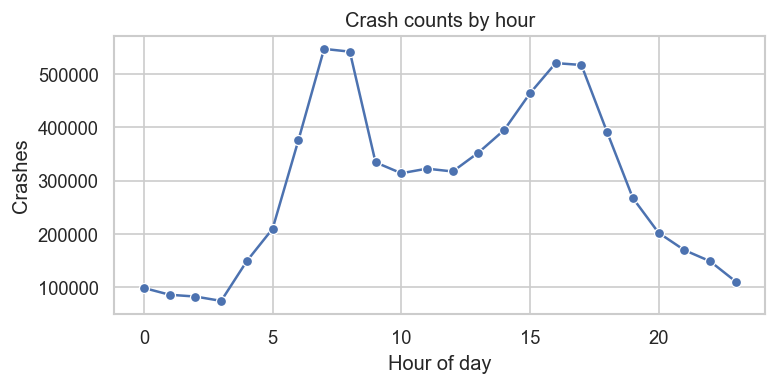

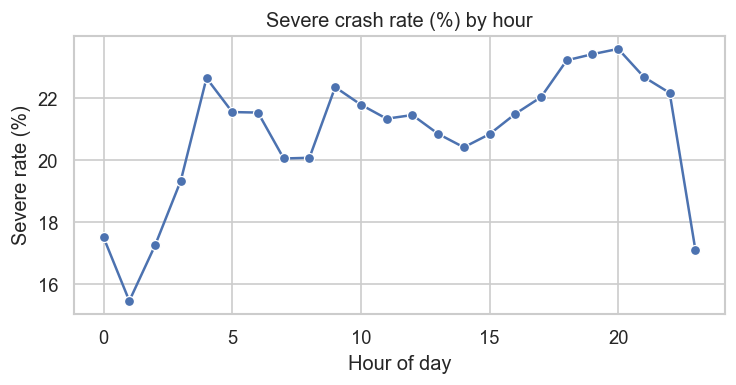

In [61]:
# Hour of day counts and SEVERE RATE

# Should be two plots right?

hour_tab = rate_table(df_prep, "hour").sort_values("hour")
fig, ax = plt.subplots(figsize=(7,3))
sns.lineplot(data = hour_tab, x = "hour", y = "crashes", marker = "o", ax = ax)
ax.set_title("Crash counts by hour")
ax.set_xlabel("Hour of day"); ax.set_ylabel("Crashes")
plt.show()

# Lots of crashes between 5 and 10 and 15 to 20 (it decreases here though)

fig, ax = plt.subplots(figsize = (7, 3))
sns.lineplot(data=hour_tab, x="hour", y="severe_rate", marker = "o", ax=ax)
ax.set_title("Severe crash rate (%) by hour")
ax.set_xlabel("Hour of day"); ax.set_ylabel("Severe rate (%)")
plt.show()

# Peaks at 20 with the lowest (minima) at 1 or 2?

In [ ]:
# Overriding the helper I created above (if you dont it bugs)

def rate_table(df, by):
    if by not in df.columns:
        raise KeyError(f"{by!r} not in DataFrame. Have: {list(df.columns)[:12]} ...")
    t = (df.groupby(by)["severe_bin"]
           .agg(crashes="size", severe_rate=lambda s: s.mean()*100)
           .reset_index())
    t["crashes"] = t["crashes"].astype(int)
    t["severe_rate"] = t["severe_rate"].astype(float)
    return t

      When  crashes  severe_rate
0  Weekday  6659126     18.66329
1  Weekend  1069268     24.43120


/var/folders/md/0v61c81x7x36g2p3469grvlm0000gn/T/ipykernel_37069/689314064.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wk_tab, x="When", y="severe_rate", ax=ax, palette="muted")


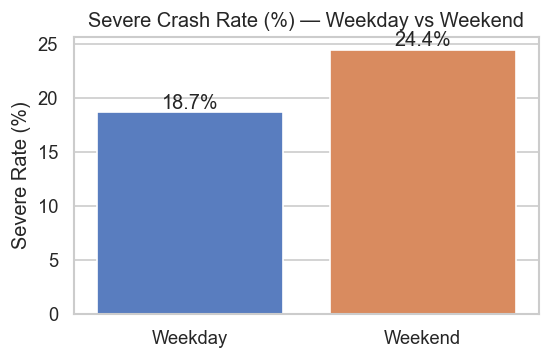

     Period  crashes  severe_rate
0  Non-rush  4878471    18.341177
1      Rush  2849923    21.378753


/var/folders/md/0v61c81x7x36g2p3469grvlm0000gn/T/ipykernel_37069/689314064.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rh_tab, x="Period", y="severe_rate", ax=ax, palette="muted")


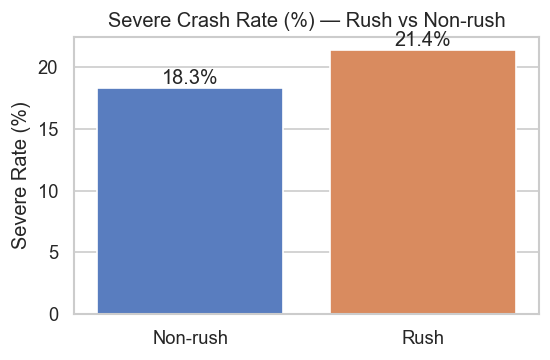

In [67]:
# Weekend vs Weekday & Rush vs NonRush


# Rebuilding because it broke last time

# Rebuild 
wk_tab = (rate_table(df_prep, "is_weekend")
          .replace({"is_weekend": {0:"Weekday", 1:"Weekend"}})
          .rename(columns={"is_weekend":"When"}))

print(wk_tab)  # check

# Plot
fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(data=wk_tab, x="When", y="severe_rate", ax=ax, palette="muted")
ax.set_title("Severe Crash Rate (%) — Weekday vs Weekend")
ax.set_ylabel("Severe Rate (%)"); ax.set_xlabel("")
for i, v in enumerate(wk_tab["severe_rate"]):
    ax.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.show()

# No longer looks the same :)

# We can see that there are more crashes during the weekend than the weekday!

# Rush vs Non
# Rebuild 
rh_tab = (rate_table(df_prep, "rush_hour")
          .replace({"rush_hour": {0:"Non-rush", 1:"Rush"}})
          .rename(columns={"rush_hour":"Period"}))

print(rh_tab)  # check

# Plot
fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(data=rh_tab, x="Period", y="severe_rate", ax=ax, palette="muted")
ax.set_title("Severe Crash Rate (%) — Rush vs Non-rush")
ax.set_ylabel("Severe Rate (%)"); ax.set_xlabel("")
for i, v in enumerate(rh_tab["severe_rate"]):
    ax.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.show()

In [68]:
# Redefine the helper again (im having so much trouble)

# Helper returns -=- <group>, crashes, severe_rate (%)
def rate_table(df, by):
    t = (df.groupby(by)["severe_bin"]
           .agg(crashes="size", severe_rate=lambda s: s.mean()*100)
           .reset_index())
    t["crashes"] = t["crashes"].astype(int)
    t["severe_rate"] = t["severe_rate"].astype(float)
    return t

# Make sure 'is_dark' exists
if "is_dark" not in df_prep.columns:
    if "Sunrise_Sunset" in df_prep.columns:
        df_prep["is_dark"] = df_prep["Sunrise_Sunset"].astype(str).str.lower().eq("night").astype("int8")
    else:
        # fallback by hour
        if "hour" not in df_prep.columns:
            df_prep["Start_Time"] = pd.to_datetime(df_prep["Start_Time"], errors="coerce")
            df_prep["hour"] = df_prep["Start_Time"].dt.hour
        df_prep["is_dark"] = df_prep["hour"].isin([0,1,2,3,4,5,19,20,21,22,23]).astype("int8")

print("Debug Check: is_dark value counts\n", df_prep["is_dark"].value_counts(dropna=False))

Debug Check: is_dark value counts
 is_dark
0    5357799
1    2370595
Name: count, dtype: int64


Day/Night table:
   Lighting  crashes  severe_rate
0      Day  5357799    19.700646
1    Night  2370595    18.920398


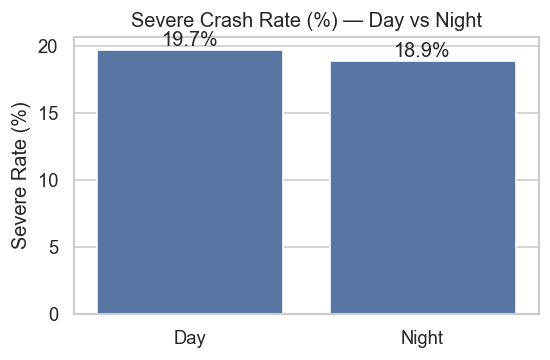

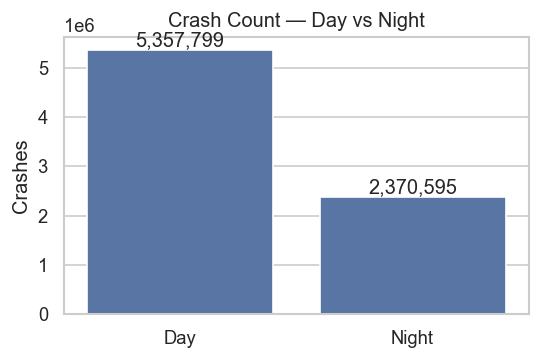

In [ ]:
# Day vs Night
light_tab = (rate_table(df_prep, "is_dark")
             .replace({"is_dark": {0:"Day", 1:"Night"}})
             .rename(columns={"is_dark":"Lighting"}))

print("Day/Night table:\n", light_tab)

fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(data=light_tab, x="Lighting", y="severe_rate", ax=ax)
ax.set_title("Severe Crash Rate (%) — Day vs Night")
ax.set_ylabel("Severe Rate (%)"); ax.set_xlabel("")
for i, v in enumerate(light_tab["severe_rate"]):
    ax.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.show()

fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(data=light_tab, x="Lighting", y="crashes", ax=ax)
ax.set_title("Crash Count — Day vs Night")
ax.set_ylabel("Crashes"); ax.set_xlabel("")
for i, v in enumerate(light_tab["crashes"]):
    ax.text(i, v, f"{v:,}", ha="center", va="bottom")
plt.show()

# Way more during the day!

  Weather_Simple  crashes  severe_rate
4           Rain   540375    23.402452
1         Cloudy  3163750    21.652754
3          Other   178062    21.538004
5           Snow   173360    19.468736
6          Storm    65232    18.191992
0          Clear  3405216    16.908472
2            Fog   202399    16.209566


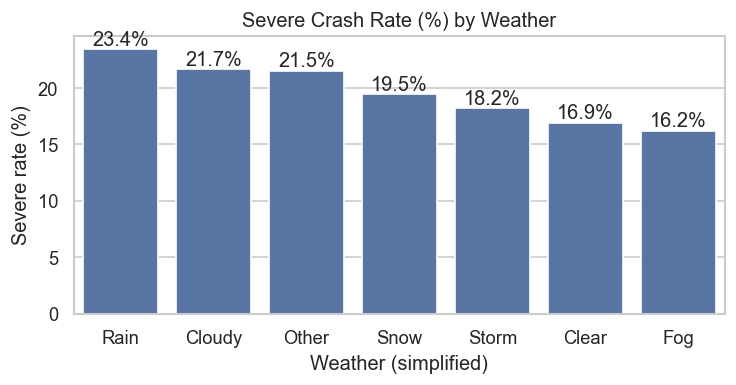

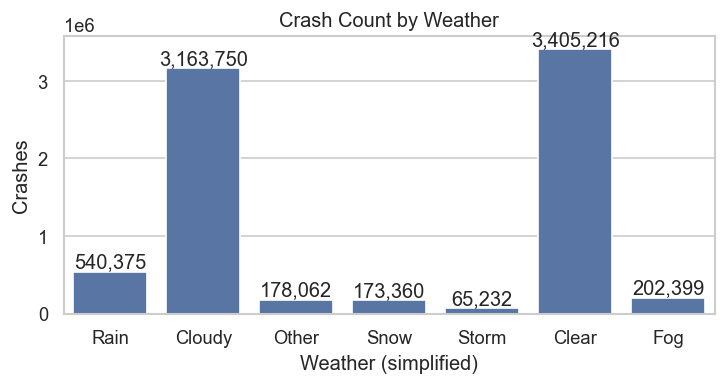

In [ ]:
# Weather con

assert "Weather_Simple" in df_prep.columns, "Run the prep step that creates Weather_Simple first." # hopefully this works??

wx_tab = (rate_table(df_prep, "Weather_Simple")
          .sort_values("severe_rate", ascending=False))
print(wx_tab)

fig, ax = plt.subplots(figsize=(7,3))
sns.barplot(data=wx_tab, x="Weather_Simple", y="severe_rate", ax=ax)
ax.set_title("Severe Crash Rate (%) by Weather")
ax.set_xlabel("Weather (simplified)") ; ax.set_ylabel("Severe rate (%)")
for i, v in enumerate(wx_tab["severe_rate"]):
    ax.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.show()

# show counts too so stakeholders see frequency vs risk
fig, ax = plt.subplots(figsize=(7,3))
sns.barplot(data=wx_tab, x="Weather_Simple", y="crashes", ax=ax)
ax.set_title("Crash Count by Weather")
ax.set_xlabel("Weather (simplified)") ; ax.set_ylabel("Crashes")
for i, v in enumerate(wx_tab["crashes"]):
    ax.text(i, v, f"{v:,}", ha="center", va="bottom")
plt.show()


# Way more wrecks during Cloudy and Clear but higher Sev during rain...

Top by count:
    State  crashes  severe_rate
3     CA  1741433    16.383978
8     FL   880192    13.316867
41    TX   582837    21.901835
38    SC   382557    11.910643
32    NY   347960    23.224221
25    NC   338199    11.825582
43    VA   303301    22.923103
36    PA   296620    15.810802
21    MN   192084    16.007059
35    OR   179660     8.696427
2     AZ   170609    13.285935
9     GA   169234    43.738847
12    IL   168958    36.733981
40    TN   167388    19.116663
20    MI   162191    29.670574


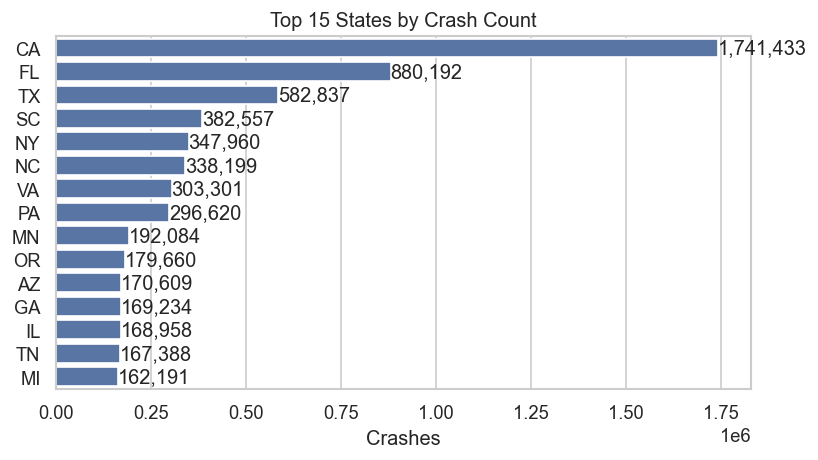

Top by severe rate (min 5,000 crashes):
    State  crashes  severe_rate
37    RI    16971    46.237700
9     GA   169234    43.738847
15    KY    32254    42.500155
46    WI    34688    37.672970
4     CO    90885    37.200858
12    IL   168958    36.733981
22    MO    77323    36.582905
10    IA    26307    34.298856
30    NM    10325    33.142857
13    IN    67224    31.955849
45    WA   108221    31.432901
33    OH   118115    31.355882
17    MA    61996    30.921350
20    MI   162191    29.670574
14    KS    20992    29.158727


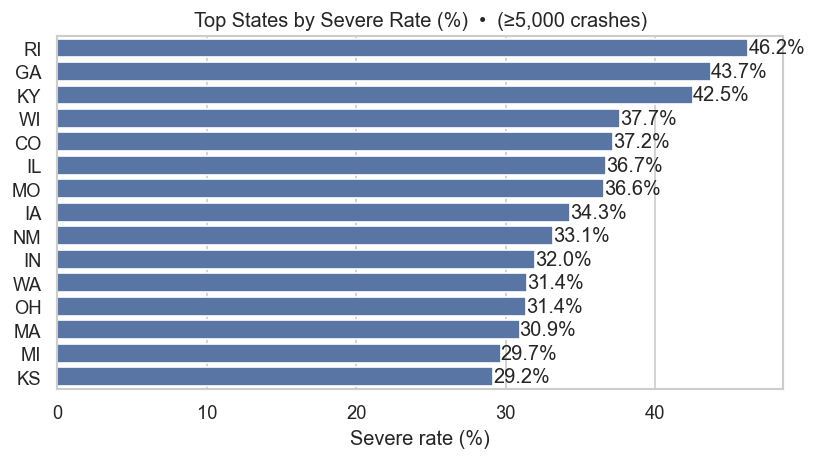

In [ ]:
# States. This could be interesting! 

state_tab = rate_table(df_prep, "State")


# Top by crash count
top_by_count = state_tab.sort_values("crashes", ascending=False).head(15)
print("Top by count:\n", top_by_count)

fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(data=top_by_count, y="State", x="crashes", ax=ax)
ax.set_title("Top 15 States by Crash Count")
ax.set_xlabel("Crashes"); ax.set_ylabel("")
for i, v in enumerate(top_by_count["crashes"]):
    ax.text(v, i, f"{v:,}", va="center", ha="left")
plt.tight_layout(); plt.show()

# Top by sev rate

floor = 5_000
top_by_rate = (state_tab[state_tab["crashes"] >= floor]
               .sort_values("severe_rate", ascending=False)
               .head(15))
print(f"Top by severe rate (min {floor:,} crashes):\n", top_by_rate) # I keep using \n but im note sure its required...

fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(data=top_by_rate, y="State", x="severe_rate", ax=ax)
ax.set_title(f"Top States by Severe Rate (%)  •  (≥{floor:,} crashes)")
ax.set_xlabel("Severe rate (%)"); ax.set_ylabel("")
for i, v in enumerate(top_by_rate["severe_rate"]):
    ax.text(v, i, f"{v:.1f}%", va="center", ha="left")
plt.tight_layout(); plt.show()

# So... CA, FL, and TX have the worst drivers but Rhode Island has the more severe? 

Infra columns to chart: ['Traffic_Signal', 'Junction', 'Crossing', 'Railway', 'Stop', 'No_Exit']
  Traffic Signal  crashes  severe_rate
0             No  6584622    21.190100
1            Yes  1143772     9.508801


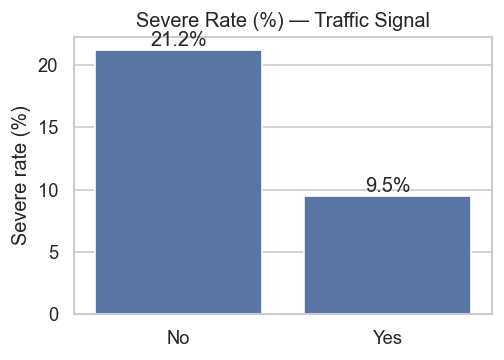

  Junction  crashes  severe_rate
0       No  7157052    18.876082
1      Yes   571342    26.792359


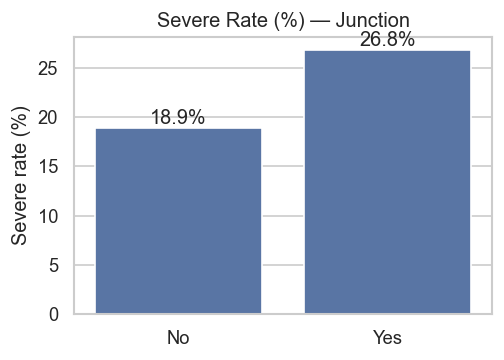

  Crossing  crashes  severe_rate
0       No  6854631    21.044473
1      Yes   873763     7.041498


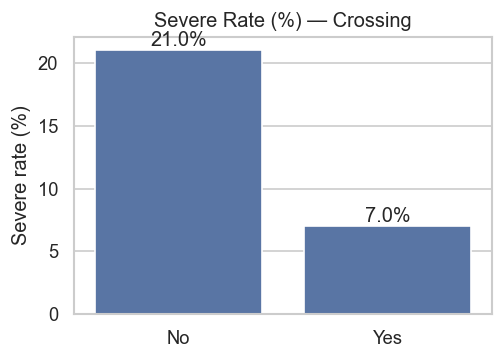

  Railway  crashes  severe_rate
0      No  7661415    19.499179
1     Yes    66979    15.130115


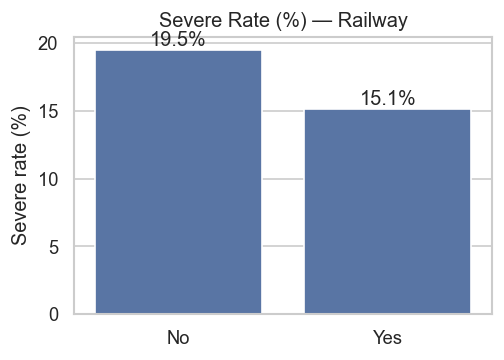

  Stop  crashes  severe_rate
0   No  7514023    19.839026
1  Yes   214371     6.221924


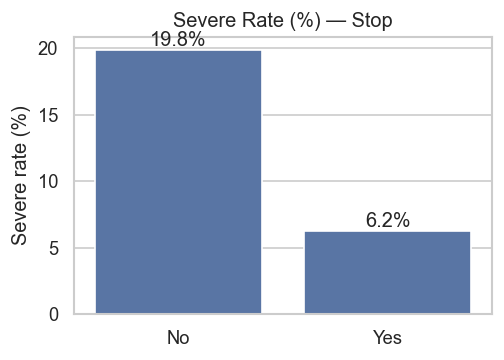

  No Exit  crashes  severe_rate
0      No  7708849    19.482065
1     Yes    19545    11.276541


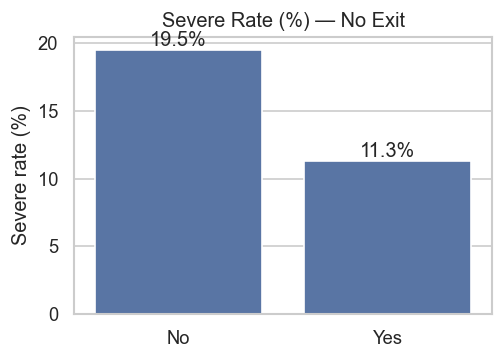

In [75]:
# Infra
infra_cols = [c for c in ["Traffic_Signal","Junction","Crossing","Railway","Stop","No_Exit"] if c in df_prep.columns]
print("Infra columns to chart:", infra_cols)

# Perfect

for col in infra_cols:
    tmp = (rate_table(df_prep, col)
           .replace({col: {0:"No", 1:"Yes"}})
           .rename(columns={col: col.replace("_"," ")}))
    print(tmp)

    fig, ax = plt.subplots(figsize=(4.5,3))
    sns.barplot(data=tmp, x=col.replace("_"," "), y="severe_rate", ax=ax)
    ax.set_title(f"Severe Rate (%) — {col.replace('_',' ')}")
    ax.set_ylabel("Severe rate (%)"); ax.set_xlabel("")
    for i, v in enumerate(tmp["severe_rate"]):
        ax.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
    plt.show()

Unique weekdays present: [0, 1, 2, 3, 4, 5, 6]
Counts by weekday:
 weekday
0       1108807
1       1177923
2       1195864
3       1196137
4       1237229
5        579153
6        490115
<NA>     743166
Name: count, dtype: Int64
Any NaNs in hour/weekday? 743166 hour NaNs, 743166 weekday NaNs
Pivots shapes (should be 7x24): (7, 24) (7, 24)


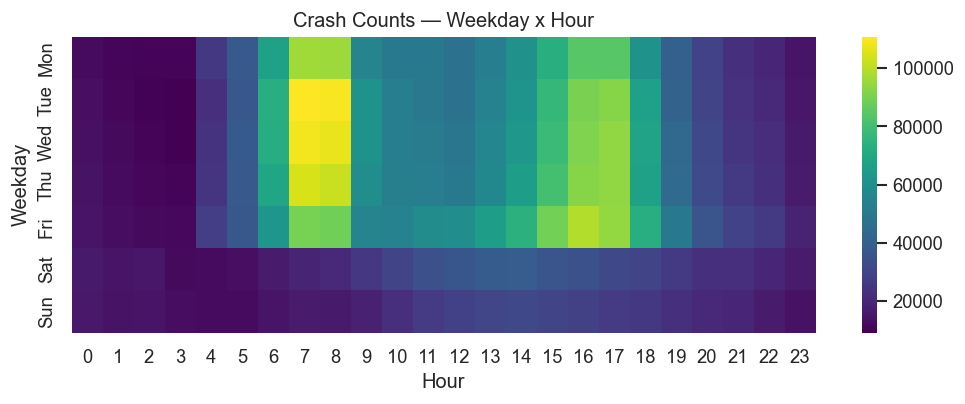

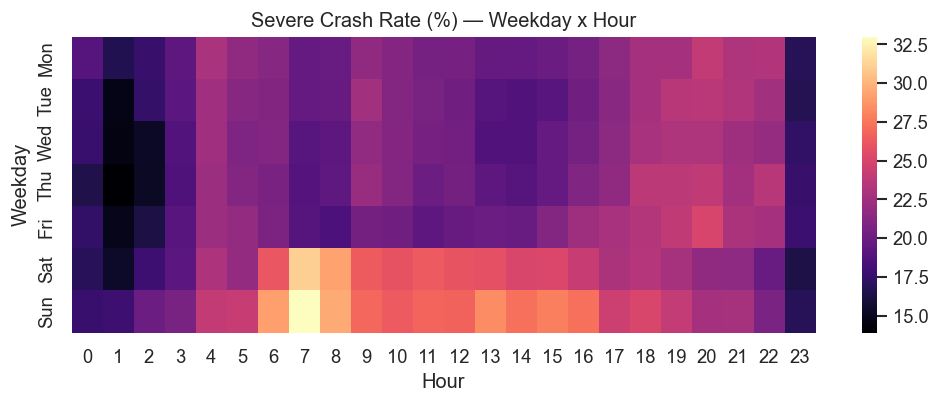

In [ ]:
# Heatmaps

print("Unique weekdays present:", sorted(df_prep["weekday"].dropna().unique().tolist()))
print("Counts by weekday:\n", df_prep["weekday"].value_counts(dropna=False).sort_index())
print("Any NaNs in hour/weekday?",
      df_prep["hour"].isna().sum(), "hour NaNs,",
      df_prep["weekday"].isna().sum(), "weekday NaNs")

df_plot = df_prep.dropna(subset=["hour","weekday"]).copy()

# the following has all been done so that we can get 7 days :D
# Enforce integer type (not float) so ordering is clean 
df_plot["hour"] = df_plot["hour"].astype(int)
df_plot["weekday"] = df_plot["weekday"].astype(int)

# Full grids we want to show
full_wd = pd.Index(range(7), name="weekday")   # 0..6
full_hr = pd.Index(range(24), name="hour")     # 0..23

# COUNT pivot
count_piv = (df_plot
             .pivot_table(index="weekday", columns="hour",
                          values="severe_bin", aggfunc="size")
             .reindex(index=full_wd, columns=full_hr, fill_value=0))

# RATE pivot
rate_piv = (df_plot
            .pivot_table(index="weekday", columns="hour",
                         values="severe_bin", aggfunc="mean")
            .reindex(index=full_wd, columns=full_hr))

# Label
wd_map = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}
count_piv.index = [wd_map[i] for i in count_piv.index]
rate_piv.index  = [wd_map[i] for i in rate_piv.index]

print("Pivots shapes (should be 7x24):", count_piv.shape, rate_piv.shape)

# Plot
fig, ax = plt.subplots(figsize=(10,3.2))
sns.heatmap(count_piv, cmap="viridis", ax=ax)
ax.set_title("Crash Counts — Weekday x Hour") # x looks best imo...
ax.set_xlabel("Hour"); ax.set_ylabel("Weekday")
plt.show()

fig, ax = plt.subplots(figsize=(10,3.2))
sns.heatmap(rate_piv*100, cmap="magma", ax=ax)
ax.set_title("Severe Crash Rate (%) — Weekday x Hour")
ax.set_xlabel("Hour"); ax.set_ylabel("Weekday")
plt.show()

# So what we can gather from this is that there are more wrecks on the weekdays than the weekend but there are higher sev wrecks on the weekend than the weekdays.

Continuous columns to plot: ['Visibility(mi)', 'Precipitation(in)', 'Wind_Speed(mph)', 'Distance(mi)', 'Temperature(F)']


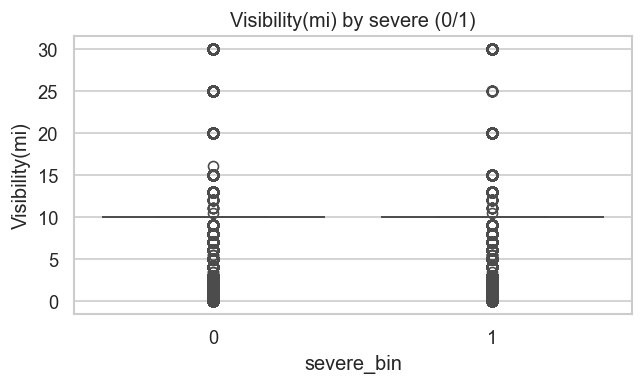

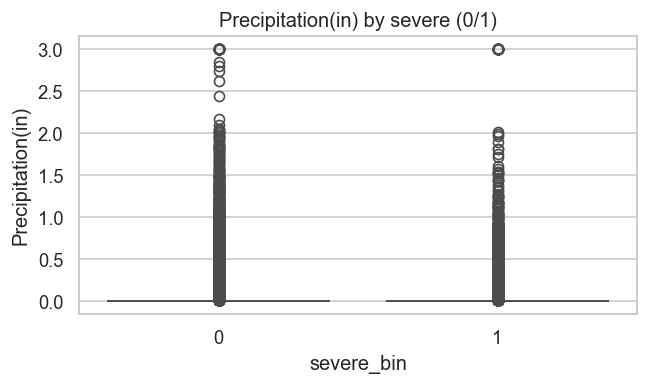

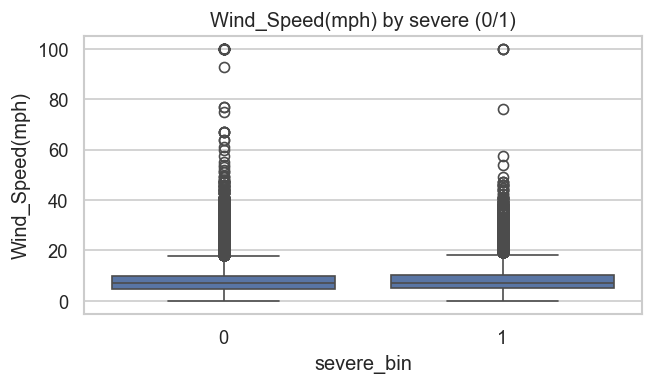

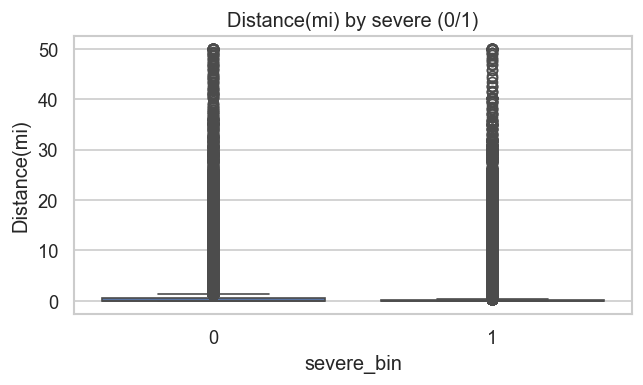

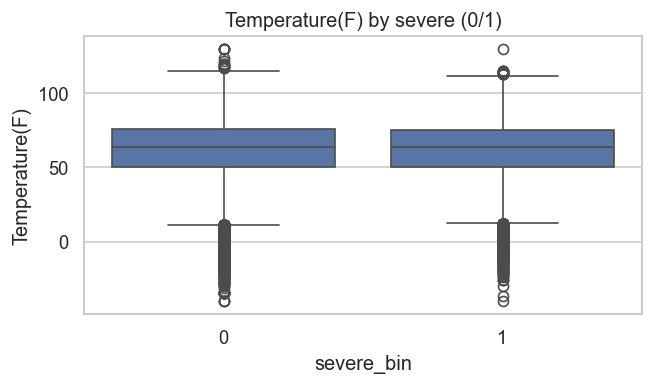

In [79]:
df_box = df_prep.sample(1_000_000, random_state=0) if len(df_prep) > 1_000_000 else df_prep

cont_cols = [c for c in ["Visibility(mi)","Precipitation(in)","Wind_Speed(mph)","Distance(mi)","Temperature(F)"] if c in df_box.columns]
print("Continuous columns to plot:", cont_cols)

for col in cont_cols:
    fig, ax = plt.subplots(figsize=(6,3))
    sns.boxplot(data=df_box, x="severe_bin", y=col, ax=ax)
    ax.set_title(f"{col} by severe (0/1)")
    ax.set_xlabel("severe_bin"); ax.set_ylabel(col)
    plt.show()

## Statistical Data Analysis


In [ ]:
# We are going to use scikit-learn instead of statsmodels

# Predictiors
num_cols = [c for c in ["Visibility(mi)","Precipitation(in)","Wind_Speed(mph)","Distance(mi)","Temperature(F)"] if c in df_prep.columns]
cat_cols = [c for c in ["Weather_Simple"] if c in df_prep.columns]
bin_cols = [c for c in ["is_dark","rush_hour"] if c in df_prep.columns]

use_cols = ["severe_bin"] + num_cols + cat_cols + bin_cols
log_df = df_prep[use_cols].dropna().copy()

X = log_df.drop(columns=["severe_bin"])
y = log_df["severe_bin"].astype(int)

print("Model data:", X.shape, " (rows, cols)")
print("Numerical:", num_cols)
print("Categorical:", cat_cols)
print("Binary:", bin_cols)

# looks good


Model data: (7728394, 8)  (rows, cols)
Numerical: ['Visibility(mi)', 'Precipitation(in)', 'Wind_Speed(mph)', 'Distance(mi)', 'Temperature(F)']
Categorical: ['Weather_Simple']
Binary: ['is_dark', 'rush_hour']


In [91]:
# Deploying the scikit pipeline
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("pas", "passthrough", bin_cols),
    ],
    remainder="drop",
)

logit = LogisticRegression( #right?
    solver = "saga", # Im using this because it handles a lot of large and sparse data really well from my previous tests
    max_iter = 400,
    n_jobs = 1,
    class_weight = "balanced", # We are going to have to cope with some of the imbalances in the data
    penalty = "l2",
    C = 1.0,
)



pipe = Pipeline([("pre", pre), ("clf", logit)])
pipe.fit(X, y) # forgot no para around fit -_-

print("Fitted. Classes:", pipe.named_steps["clf"].classes_)






Fitted. Classes: [0 1]


In [ ]:
# Feature names and ratios

# Lets first build a helper to recover some of our feature names
def get_feature_names(ct, num_cols, cat_cols, bin_cols):
    names = []
    # numeric
    names += num_cols
    # categorical (expand)
    if cat_cols:
        ohe = ct.named_transformers_["cat"]
        cat_feats = []
        for i, col in enumerate(cat_cols):
            cats = list(ohe.categories_[i])[1:]
            cat_feats += [f"{col}={c}" for c in cats]
        names += cat_feats
    # binary passthrough
    names += bin_cols
    return names

feature_names = get_feature_names(pipe.named_steps["pre"], num_cols, cat_cols, bin_cols)
coefs = pipe.named_steps["clf"].coef_.ravel()

odds = pd.DataFrame({
    "feature": feature_names,
    "coef_logit": coefs,
    "odds_ratio": np.exp(coefs)
}).sort_values("odds_ratio", ascending=False)

display(odds.head(12))
display(odds.tail(12))

# It worked really nicely

,feature,coef_logit,odds_ratio
8,Weather_Simple=Rain,0.379600,1.461700
7,Weather_Simple=Other,0.296906,1.345689
5,Weather_Simple=Cloudy,0.281725,1.325415
12,rush_hour,0.203354,1.225506
9,Weather_Simple=Snow,0.177942,1.194756
2,Wind_Speed(mph),0.096008,1.100767
11,is_dark,0.064261,1.066370
6,Weather_Simple=Fog,0.035085,1.035708
1,Precipitation(in),0.027223,1.027597
0,Visibility(mi),0.021880,1.022121


,feature,coef_logit,odds_ratio
7,Weather_Simple=Other,0.296906,1.345689
5,Weather_Simple=Cloudy,0.281725,1.325415
12,rush_hour,0.203354,1.225506
9,Weather_Simple=Snow,0.177942,1.194756
2,Wind_Speed(mph),0.096008,1.100767
11,is_dark,0.064261,1.066370
6,Weather_Simple=Fog,0.035085,1.035708
1,Precipitation(in),0.027223,1.027597
0,Visibility(mi),0.021880,1.022121
4,Temperature(F),0.011680,1.011749


In [ ]:
# I want to bootstrap CIs for odds

from sklearn.utils import resample # Im going to drop this here because otherwise you could skip this part if you would like!

N = min(len(log_df), 300_000)
sub = log_df.sample(N, random_state=0)
Xb, yb = sub.drop(columns=["severe_bin"]), sub["severe_bin"].astype(int)
B = 120
coef_boot = np.zeros((B, len(feature_names)))

for b in range(B):
    Xbs, ybs = resample(Xb, yb, replace=True, random_state=b)
    pipe.fit(Xbs, ybs)
    coef_boot[b, :] = pipe.named_steps["clf"].coef_.ravel()

coef_df = pd.DataFrame(coef_boot, columns=feature_names)
ci = coef_df.quantile([0.025, 0.975]).T
out = odds.merge(ci, left_on="feature", right_index=True, how="left")
out = out.rename(columns={0.025:"coef_low", 0.975:"coef_high"})
out["OR_low"]  = np.exp(out["coef_low"])
out["OR_high"] = np.exp(out["coef_high"])

display(out[["feature","odds_ratio","OR_low","OR_high"]].sort_values("odds_ratio", ascending=False).round(3))


# I ended the run of this cell. Its not error! It just took way too long and I didnt want to wait.


KeyboardInterrupt: 

Small Analysis...

There are a few main takeaways that should be noted from the above logistic regression.

First off Weather Conditions seem to have the largest impact. Crashes in the rain are roughly 46% more likely to be severe than clear weather. Clody and other weather conditions increase odds by 30-35%. Surprisingly, Snow only increased it by ~19%! Moving on to rush hour. During rush hour, severe crash odds go up roughly ~23% from baseline conditions. Night driving only increases the odds by ~7%. 

It should also be noted that weather intensities like wind_speed or precip, and distance only moderately increase the odds.

## Evaluation

### Business Insight/Recommendation 1 : Weather Effects


Insight:

Rain seems to have the highest severe crash rate (~23.4%), followed by cloudy and "other" adverse weather conditions. Clear weather and fog have the lowest severity percentages.

Recommendation: 

My recommendation would be to launch a public awareness campaign to educate people about safe driving in the rain. For example, teach about reducing speed and increasing overall follow distance, etc..

Secondly, we should work with navigation systems and apps to issue real-time warnings when the user is driving in the rain. It shouldn't be too bad! 

### Business Insight/Recommendation 2 : Rush Hour

Insight:
Rush hour shows a notably higher severe crash rate (at ~21.4%) compared to non-rush (roughly ~18.3%)


Recommendations:
We should encourage flexible work hours/remote work/or external work opportunities to reduce rush-hour traffic density. By reducing, we can drive the rates downward.

Additionally, we could introduce dynamic speed limits or promote alternative sources of transportation beyond driving.

Lastly, consider implementing a carpooling or staggered end-of-day hours schedule.

### Business Insight/Recommendation 3 : Lighting (Day vs. Night)

Insight:
Crash counts at night are significantly higher than during the day (~5.3 million vs 2.3 million), but severity rates are still relatively close to each other (19.7% - 18.9% at night). 

Recommendations:
Overall volume is a significant factor in daytime crashes. We should employ targeted congestion management strategies to reduce the overall volume...

At night, we should implement better lighting (at least here in Texas; 1/3 of the highways are not lit yet...).

Overall, however, we should focus on reducing overall traffic exposure during peak daytime hours and then aim to drive nighttime counts down.

In [95]:
# Exporting CSVs for Tableau

# Weather summary
weather_tab = df_prep.groupby("Weather_Simple")["severe_bin"].agg(
    crashes="count", 
    severe_rate=lambda x: 100*x.mean()
).reset_index()
weather_tab.to_csv("weather_summary.csv", index=False)

# Day vs Night summary
light_tab = df_prep.groupby("is_dark")["severe_bin"].agg(
    crashes="count", 
    severe_rate=lambda x: 100*x.mean()
).reset_index().replace({0:"Day",1:"Night"})
light_tab.to_csv("lighting_summary.csv", index=False)

# Rush hour summary
rush_tab = df_prep.groupby("rush_hour")["severe_bin"].agg(
    crashes="count", 
    severe_rate=lambda x: 100*x.mean()
).reset_index().replace({0:"Non-rush",1:"Rush"})
rush_tab.to_csv("rush_summary.csv", index=False)

# Hour x Weekday heatmap
heatmap_tab = df_prep.groupby(["weekday","hour"])["severe_bin"].agg(
    crashes="count", 
    severe_rate=lambda x: 100*x.mean()
).reset_index()
heatmap_tab.to_csv("heatmap_summary.csv", index=False)

### Tableau Dashboard link : https://public.tableau.com/views/TRAF-Proj/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link


In [96]:
# I only used weather stats because I was unable to import any of the others. I'm not sure if my Tableau version is corrupted or something, but every time I imported it, it would crash to the desktop... I'm sorry for the inconvenience

## Conclusion
Our analysis of crash data was very fruitful in my opinion. It gave us several important insights (and surprises that I didn't expect!). What we learned from this activity is that weather conditions strongly influence severity rates: rain and cloudy conditions show the highest severity crash rates. In contrast, clear conditions seem to have the lowest severity despite the highest volume of crashes. Rush hour is associated with higher severe crash rates compared to non-rush periods, which confirms the overall added risks of metropolitan congestion. Daytime crashes are more frequent than nighttime crashes, but the severity is slightly higher at night, suggesting that visibility may be a contributing factor.

I ultimately used logistic regression to confirm these findings, which indicate that rain, cloudy weather, and rush hour are significant predictors of severe crashes. This indicates that targeted interventions (such as PSA's, roadway lighting, speed enforcement, and traffic management strategies) could help mitigate overall risks on our roadways.

However, this study had some pretty severe limitations. The dataset does not accurately capture driver behavior (such as fatigue, distractions, and the presence of passengers in the car) or the vehicle's overall condition, both of which may play a role in determining the severity of a crash. In addition, the logistic regression model provided us with interpretable odds ratios, which may have oversimplified the interactions between the various behaviors that are already present...

In the future, I would integrate additional data sources as well as real-time data. To capture the most accurate results, we need data on traffic flow, vehicle safety features, models, driver demographics, and other relevant factors, which would allow us to create a more advanced machine learning model to uncover non-linear interactions between these data sources.